In [1]:
import pickle
import tempfile
import pydot
import graphviz
import numpy as np
import tensorflow as tf
from get_data import *
from model import *
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
MAX_SEQ_LEN = 42
EMBEDDING_DIM = 300
VOCAB_SIZE = 20000

In [4]:
data = read_data()
train_data = data[:3]
test_data = data[3:]

In [5]:
def differentiate_inputs(a, b):
    ans = []
    for i in a:
        if i not in b:
            ans.append(i)
    return ans

In [6]:
len(train_data[0][0])

550152

In [7]:
for i in range(len(train_data[0][0])):
    a = differentiate_inputs(train_data[0][0][i], train_data[1][0][i])
    b = differentiate_inputs(train_data[1][0][i], train_data[0][0][i])
    train_data[0][0][i] = a
    train_data[1][0][i] = b

In [8]:
for i in range(len(test_data[0][0])):
    a = differentiate_inputs(test_data[0][0][i], test_data[1][0][i])
    b = differentiate_inputs(test_data[1][0][i], test_data[0][0][i])
    test_data[0][0][i] = a
    test_data[1][0][i] = b

In [9]:
min_len_p = 100
min_len_h = 100
max_len_p = 0
max_len_h = 0
avg_p = 0
avg_h = 0
for i in range(len(train_data[0][0])):
    avg_p += len(train_data[0][0][i])
    avg_h += len(train_data[1][0][i])
    max_len_p = max(max_len_p, len(train_data[0][0][i]))
    max_len_h = max(max_len_h, len(train_data[1][0][i]))
    min_len_p = min(min_len_p, len(train_data[0][0][i]))
    min_len_h = min(min_len_h, len(train_data[1][0][i]))
avg_p /= len(train_data[0][0])
avg_h /= len(train_data[0][0])

In [10]:
min_len_p, min_len_h, max_len_p, max_len_h, avg_p, avg_h

(0, 0, 43, 27, 5.079657985429481, 1.945420538323954)

In [11]:
min_len_p = 100
min_len_h = 100
max_len_p = 0
max_len_h = 0
for i in range(len(test_data[0][0])):
    max_len_p = max(max_len_p, len(test_data[0][0][i]))
    max_len_h = max(max_len_h, len(test_data[1][0][i]))
    min_len_p = min(min_len_p, len(test_data[0][0][i]))
    min_len_h = min(min_len_h, len(test_data[1][0][i]))

In [12]:
min_len_p, min_len_h, max_len_p, max_len_h

(0, 0, 25, 12)

In [5]:
train_data, embed_matrix = preprocess_traindata(train_data, MAX_SEQ_LEN, EMBEDDING_DIM, VOCAB_SIZE)

Non labelled: 785
Contradiction: 183187
Neutral: 182764
Entailment: 183416


In [6]:
train_data[0].shape

(549367, 42)

In [7]:
train_data[1].shape

(549367, 42)

In [8]:
train_data[2].shape

(549367, 3)

In [9]:
l2 = 0.00002
premise = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
hypothesis = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
# prediction = create_Inner_Attention_model(premise, hypothesis, embed_matrix, l2, EMBEDDING_DIM, MAX_SEQ_LEN, baseline=False)
# prediction = create_LSTM_model(premise, hypothesis, embed_matrix, l2, EMBEDDING_DIM, MAX_SEQ_LEN, attention=True, baseline=False)
prediction = create_Novel_model(premise, hypothesis, embed_matrix, l2, EMBEDDING_DIM, MAX_SEQ_LEN, baseline=False)

# Define the complete model
model = tf.keras.models.Model(inputs=[premise, hypothesis], outputs=prediction)

# Choosing an optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.005)

# Compile the model and print out the model summary
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 300)      7802100     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 45, 300)      90300       embedding[0][0]              

In [10]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

_, tmpfn = tempfile.mkstemp()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)

callbacks = [model_checkpoint, learning_rate_reduction, early_stopping]

In [11]:
# Train the model
history = model.fit(x=[train_data[0], train_data[1]], y=train_data[2], batch_size=1024, epochs=75, validation_split=0.02, callbacks=callbacks)

Epoch 1/75
526/526 [==============================] - 156s 276ms/step - loss: 0.9350 - accuracy: 0.5785 - val_loss: 0.7518 - val_accuracy: 0.7102
Epoch 2/75
526/526 [==============================] - 140s 266ms/step - loss: 0.7309 - accuracy: 0.7191 - val_loss: 0.6810 - val_accuracy: 0.7509
Epoch 3/75
526/526 [==============================] - 147s 280ms/step - loss: 0.7012 - accuracy: 0.7422 - val_loss: 0.6652 - val_accuracy: 0.7624
Epoch 4/75
526/526 [==============================] - 146s 277ms/step - loss: 0.6849 - accuracy: 0.7548 - val_loss: 0.6598 - val_accuracy: 0.7661
Epoch 5/75
526/526 [==============================] - 145s 276ms/step - loss: 0.6771 - accuracy: 0.7607 - val_loss: 0.6470 - val_accuracy: 0.7783
Epoch 6/75
526/526 [==============================] - 146s 277ms/step - loss: 0.6680 - accuracy: 0.7666 - val_loss: 0.6420 - val_accuracy: 0.7807
Epoch 7/75
526/526 [==============================] - 145s 277ms/step - loss: 0.6609 - accuracy: 0.7708 - val_loss: 0.6352 -

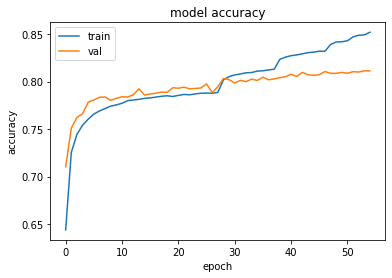

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./figures/model_acc_0.00002_0.25_1_100_300D_11.png')
plt.show()

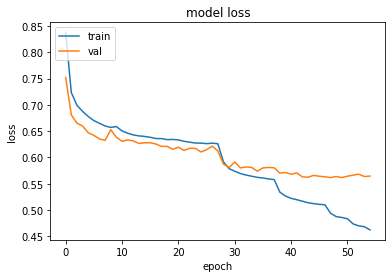

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./figures/model_loss_0.00002_0.25_1_100_300D_11.png')
plt.show()

In [14]:
test_data = data[3:]
test_data = preprocess_testdata(test_data, MAX_SEQ_LEN)

Non labelled: 176
Contradiction: 3237
Neutral: 3219
Entailment: 3368


In [15]:
loss, accuracy = model.evaluate(x=[test_data[0], test_data[1]], y=test_data[2], batch_size=512)
print("Test Loss: {:.2f}, Test Accuracy: {:.2f}%\n".format(loss, (accuracy*100)))

20/20 [==============================] - 1s 61ms/step - loss: 0.5421 - accuracy: 0.8232
Test Loss: 0.54, Test Accuracy: 82.32%



In [16]:
Y_pred = model.predict([test_data[0], test_data[1]])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(test_data[2], axis=1)

In [17]:
Y_test

array([1, 2, 0, ..., 0, 2, 1], dtype=int64)

In [18]:
Y_pred

array([1, 2, 0, ..., 0, 2, 1], dtype=int64)

In [ ]:
plt.figure(figsize=(8, 6))
ticks = ['Contradiction', 'Neutral', 'Entailment']
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
# plt.savefig('./figures/model_conf_0.00002_0.25_1_100_300D_11.png')

In [ ]:
plt.figure(figsize=(8, 6))
report = classification_report(Y_test, Y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :3].T, annot=True)
# plt.savefig('./figures/model_metrics_0.00002_0.25_1_100_300D_11.png')

In [21]:
tf.keras.models.save_model(model, './Trained Models/0.00002_0.25_1_100_300D_11.h5')

In [9]:
model1 = tf.keras.models.load_model('./Trained Models/0.00002_0.25_1_100_300D_Inner.h5', 
                                    custom_objects={'InnerAttention':InnerAttention, 
                                                    'L2':tf.keras.regularizers.l2(l2=0.00002)})

In [10]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 300)      7802100     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 42, 300)      90300       embedding_1[0][0]            

In [11]:
test_data = data[3:]
test_data = preprocess_testdata(test_data, MAX_SEQ_LEN)

Non labelled: 176
Contradiction: 3237
Neutral: 3219
Entailment: 3368


In [12]:
loss, accuracy = model1.evaluate(x=[test_data[0], test_data[1]], y=test_data[2], batch_size=1024)
print("Test Loss: {:.2f}, Test Accuracy: {:.2f}%\n".format(loss, (accuracy*100)))

10/10 [==============================] - 6s 113ms/step - loss: 0.5277 - accuracy: 0.8285
Test Loss: 0.53, Test Accuracy: 82.85%



In [13]:
Y_pred = model1.predict([test_data[0], test_data[1]])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(test_data[2], axis=1)

In [14]:
confusion_matrix(Y_test, Y_pred)

array([[2624,  337,  276],
       [ 256, 2524,  439],
       [ 118,  259, 2991]], dtype=int64)

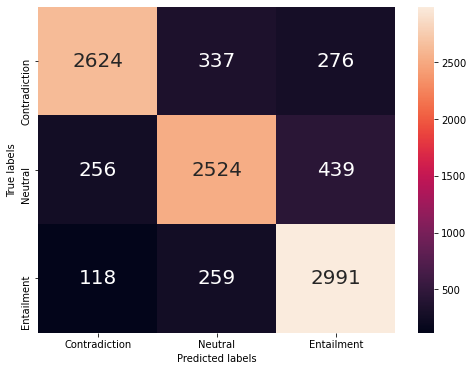

In [17]:
plt.figure(figsize=(8, 6))
ticks = ['Contradiction', 'Neutral', 'Entailment']
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks, annot_kws={"size":20})
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.savefig('./figures/best_model_conf.png')

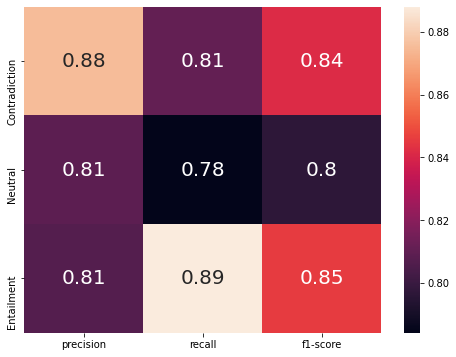

In [16]:
plt.figure(figsize=(8, 6))
report = classification_report(Y_test, Y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :3].T, annot=True, annot_kws={"size":20})
plt.savefig('./figures/best_model_metrics.png')

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)